In [1]:
import pylizard, matplotlib.pyplot as plt, pastas, pandas, numpy

## Ophalen gegevens peilbuis
Door een fout in Lizard is peilbuis BIWP0032001 geplaats op de coordinaat (0, 0) en werkt de reguliere wijze van pilzard niet. Daarom worden eerste alle peilbuizen opgehaald rond het coordinaar (0, 0) en wordt hier peilbuis BIWP32001 gehaald. 

In [2]:
df = pylizard.pnt2buis(0, 0, 100.)

In [3]:
p = df.loc['BIWP032001']

In [4]:
h_diver = pylizard.get_timeseries(p['uuid_diver'])
h_hand = pylizard.get_timeseries(p['uuid_hand'])

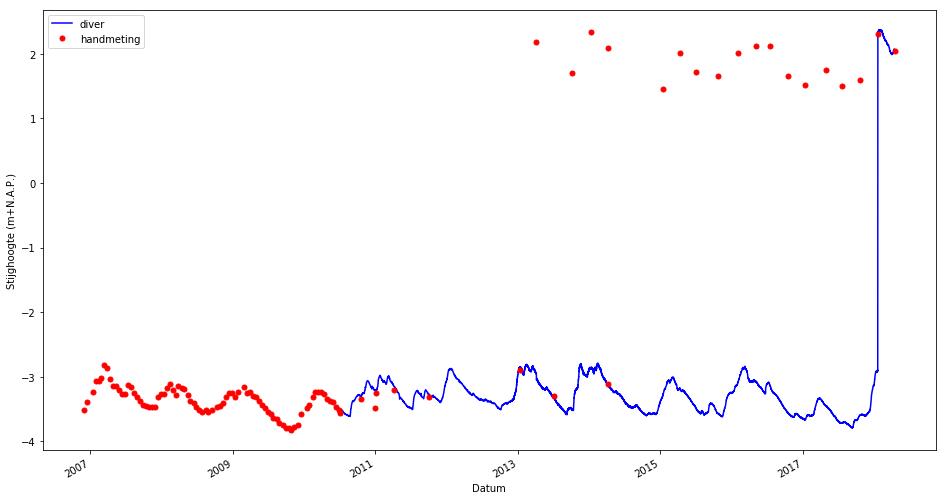

In [5]:
fig, ax = plt.subplots(figsize=[16, 9])
h_diver.plot(style='b-', label='diver')
h_hand.plot(style='r.', ms=10, label='handmeting')
ax.set_xlabel('Datum')
ax.set_ylabel('Stijghoogte (m+N.A.P.)')
ax.legend();

## Correctie, en combineren hand- en divermetingen
In de diver metingen is een sprong te zien van circa 5 meter vanaf januari 2018. Opvallend is dat in de handpeilingen deze sprong ook al zichtbaar is vanaf 2013. Het is onduidelijk wat het correcte niveau is aangezien de handpeilingen een consistent niveau van -2.5 laten zien tot 2013 en daarna een consistent beeld rond 2.0. Voor deze analyze zal het versprongen laatse diver gedeelte verlaagd worden zodat deze aansluit op de voorgaande reeks. Dit omdat het in deze analyse gaat om het aantonen danwel ontkrachten van een sprong in de grondwaterstand en niet zozeer om het absloute niveau. Bovendien laat het grootste gedeelte van de metingen het lagere nivuea zien.

Het combineren van de hand- en divermetingen zal simpelweg gebeuren door het achter elkaar plakken van de handmetingen en de gecorrigeerde diver metingen. De handmetinegn in de periode met divermetingen worden genergeerd.

In [6]:
#correctie
h_tresh = 0
h_cor = -5.2
h_diver_cor = h_diver
h_diver_cor.loc[h_diver_cor>h_tresh] += h_cor

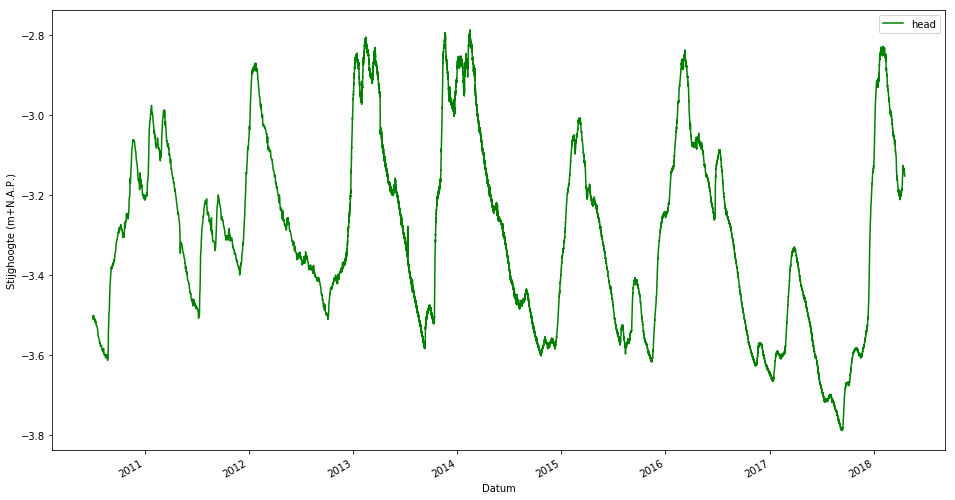

In [7]:
fig, ax = plt.subplots(figsize=[16, 9])
h_diver_cor.plot(style='g-', ax=ax)
ax.set_xlabel('Datum')
ax.set_ylabel('Stijghoogte (m+N.A.P.)')
ax.legend();

In [8]:
#Combinatie
df_concat = pandas.concat([h_hand, h_diver_cor], axis=1)
df_concat.columns = ['hand', 'diver']
df_concat['combi'] = h_diver_cor

df_concat.loc[df_concat.index.date<h_diver_cor.index.date.min(), 'combi'] = df_concat['hand']
h_combi = df_concat['combi']

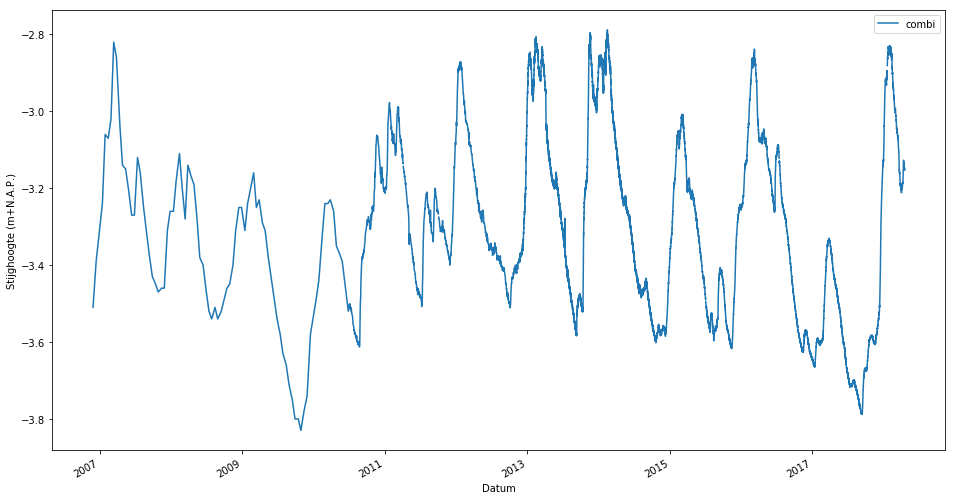

In [9]:
fig, ax = plt.subplots(figsize=[16, 9])
h_combi.plot(ax=ax)
ax.set_xlabel('Datum')
ax.set_ylabel('Stijghoogte (m+N.A.P.)')
ax.legend();

### KNMI

In [10]:
knmi_stn = pastas.read.KnmiStation(stns=260, start=str(h_combi.index.year.min()),  interval='daily')
knmi_stn.download()

rain = knmi_stn.data['RH'].resample('D').sum()
evap = knmi_stn.data['EV24'].resample('D').sum()

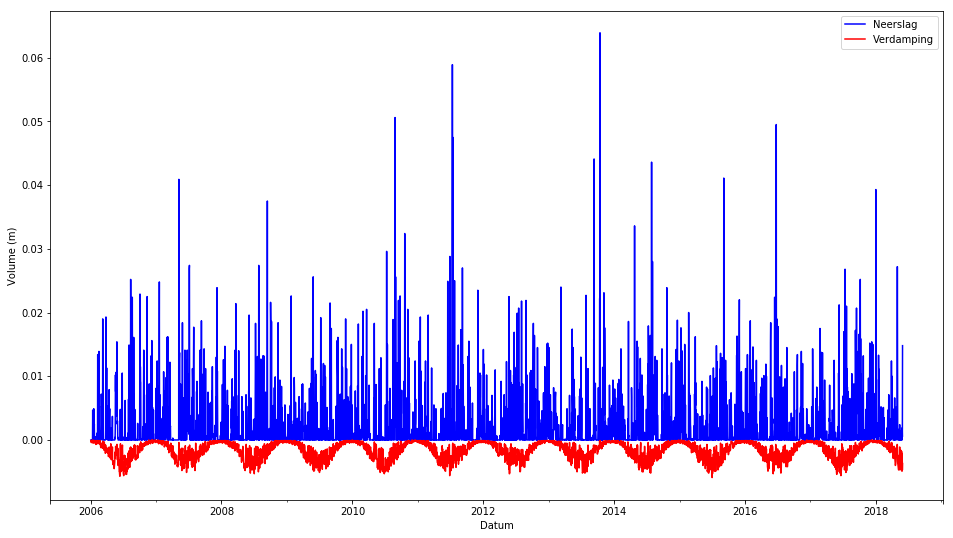

In [11]:
fig, ax = plt.subplots(figsize=[16, 9])
rain.plot(ax=ax, label='Neerslag', style='b-')
(-1*evap).plot(ax=ax, label='Verdamping', style='r-')
ax.set_xlabel('Datum')
ax.set_ylabel('Volume (m)')
ax.legend();

### Onttrekking
Voor de onttrekking is uitgegaan van twee verschillende reeksen, waarvan los van elkaar de invloed bepaald gaat worden. Dit om verschil te kunnen aantonen tussen voor en na het verdiepen van de winning.

De reeks na het verdiepen is overgenomen uit PI op dagbasis. Voor de reeks van voor de verdieping is uitgegaan van een constante onttrekking die stopt op januari 2013. 

In [12]:
well1 = pandas.Series(3871.0, index = pandas.date_range('01-01-2007', '31-12-2018', freq='1D'))
well1.loc[well1.index.year>=2013]=0

well1.index = well1.index.date

In [18]:
import piwebapi

tag = r'\\sr-16634\ACE-MN-PBTH-grondwaterverbruik'
pi=piwebapi.Point(tag)

well2 = pi.get_interpolated('01-01-2007', '*', '1D')
well2 = pandas.to_numeric(well2, errors='coerce')
well2.loc[pandas.isnull(well2)] = 0
well2 *=24
well2.index = well2.index.date

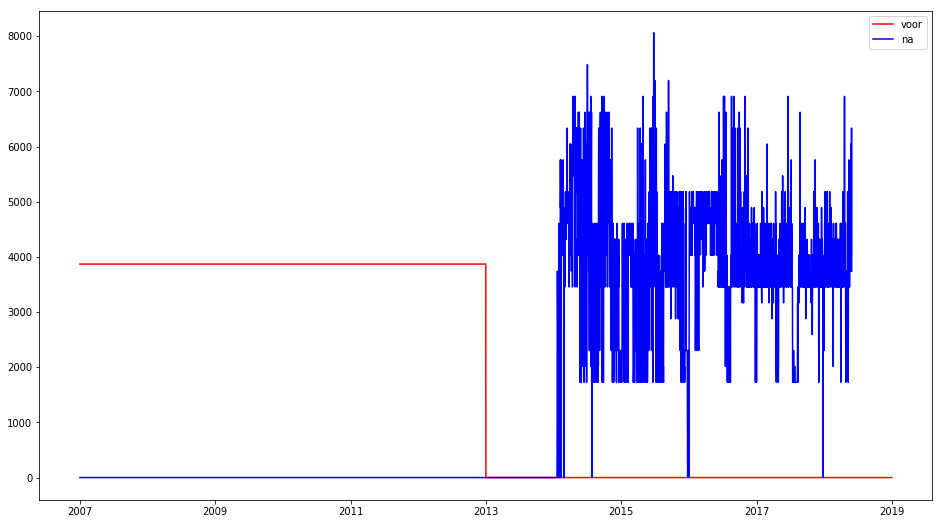

In [19]:
fig, ax = plt.subplots(figsize=[16,9])
well1.plot(style='r-', label='voor', ax=ax)
well2.plot(style='b-', label='na', ax=ax)
ax.legend();

### Tijdreeksmodel

In [20]:
ml = pastas.Model(h_combi)
sm_rain  = pastas.StressModel(rain,  pastas.Gamma, name='rain',  settings='prec')
sm_evap  = pastas.StressModel(evap,  pastas.Gamma, name='evap',  settings='evap', up=False)
sm_well1 = pastas.StressModel(well1, pastas.Gamma, name='well1', settings='well', up=False)
sm_well2 = pastas.StressModel(well2, pastas.Gamma, name='well2', settings='well', up=False)

ml.add_stressmodel(sm_rain)
ml.add_stressmodel(sm_evap)
ml.add_stressmodel(sm_well1)
ml.add_stressmodel(sm_well2)

ml.solve(tmin='2007', warmup=365)


Model Results combi                Fit Statistics
============================    ============================
nfev     43                     EVP                    84.71
nobs     2927                   NS                      0.78
noise    NoiseModel             Pearson R2              0.92
tmin     2007-01-01 00:00:00    RMSE                    0.11
tmax     2018-04-18 00:00:00    AIC                    30.23
freq     D                      BIC                   113.97
warmup   365                    __                          
solver   LeastSquares           ___                         

Parameters (14 were optimized)
                 optimal                     stderr     initial vary
rain_A        234.828023      ± 4.96962e+00 (2.12%)  425.179601    1
rain_n          1.627644      ± 6.45514e-03 (0.40%)    1.000000    1
rain_a         37.627850      ± 6.70651e-01 (1.78%)   10.000000    1
evap_A       -233.014282      ± 5.35502e+00 (2.30%) -620.583886    1
evap_n          5.13666

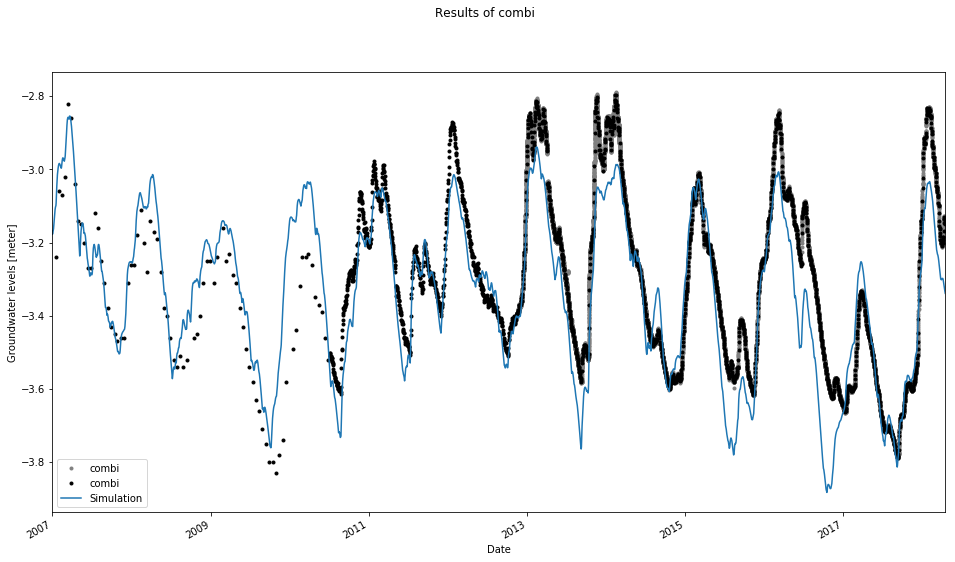

In [21]:
ml.plot(figsize=[16, 9]);

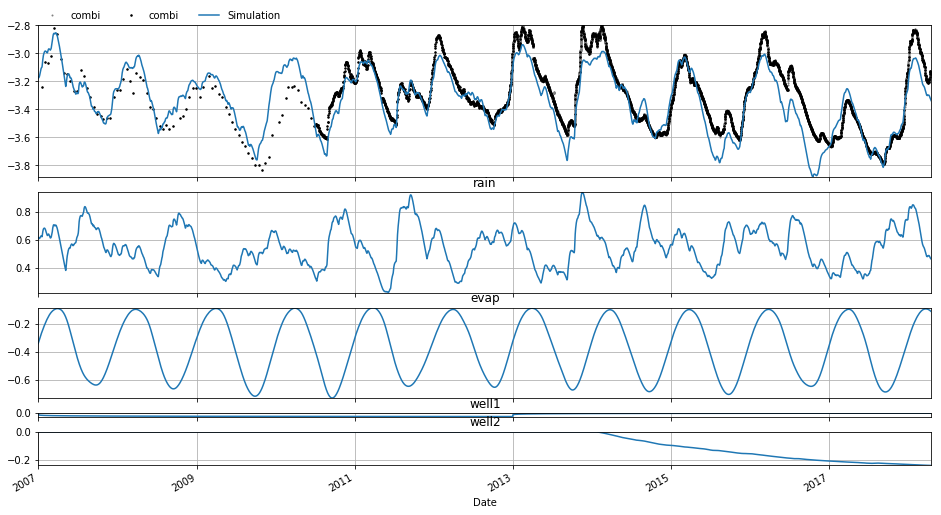

In [22]:
ml.plots.decomposition(figsize=[16,9]);

### invloed winning

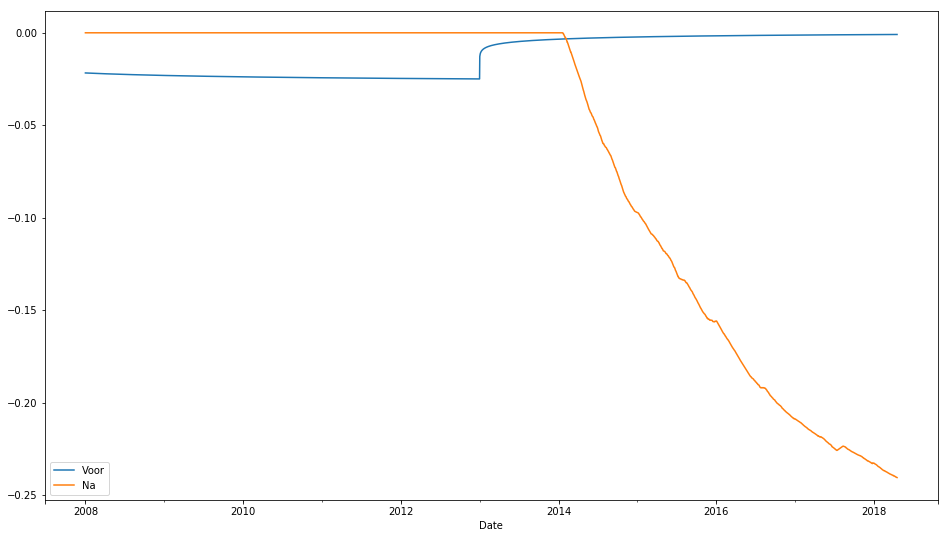

In [25]:
ml.get_contribution(name='well1', tmin='2008').plot(figsize=[16,9], label='Voor')
ml.get_contribution(name='well2', tmin='2008').plot(figsize=[16,9], label='Na')
plt.legend();